# Q3

In [2]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### General Helper Functions

In [3]:
# creates tilings in a list of size num_bins with proper offset
# create_tilings([-12],[6],2,2) == [[-18,-6,6],[-12,0,12]]
def get_tilings(state_min, state_max, num_tilings, num_bins):
    odds_to_use = [1.0, 3.0, 5.0, 7.0]
    dimension_tiles = []
    for k in range(len(state_min)):
        tiles = []
        for i in range(num_tilings):
            tiling = []
            # not perfectly generilizable but works for both envs
            if state_max[k] == math.inf or state_min[k] == -math.inf:
                tiling.append(-math.inf)
                new_min = -10.0 # 10 chosen cuz of post on ed, no real other reason
                new_max = 10.0
                absolute_range = new_max - new_min        # since Length = w * #bins-1 + w/(1+(n-1) * offset_odd)   where w is width of a tile and n is number of bins/tiles   -> w = L/(#bins-1 + 1/(1 + n * offset_odd + offset_odd))
                width = absolute_range / (num_bins-3 + 1/(1 + num_tilings * odds_to_use[k] - odds_to_use[k]))
                offset =   odds_to_use[k] * (width / (1+ (num_tilings-1) * odds_to_use[k]))
                for j in range(num_bins-1):
                    interval = new_min + j * width - i * offset
                    tiling.append(interval)
                tiling.append(math.inf)
            else:
                absolute_range = float(state_max[k]) - float(state_min[k])             # since Length = w * #bins-1 + w/(1+(n-1) * offset_odd)   where w is width of a tile and n is number of bins/tiles   -> w = L/(#bins-1 + 1/(1 + n * offset_odd + offset_odd))
                width = absolute_range / (num_bins-1 + 1/(1 + num_tilings * odds_to_use[k] - odds_to_use[k]))
                offset =   odds_to_use[k] * (width / (1+ (num_tilings-1) * odds_to_use[k]))
                for j in range(num_bins+1):
                    interval = state_min[k] + j * width - i * offset
                    tiling.append(interval)
            tiles.append(tiling)
        dimension_tiles.append(tiles)
    return dimension_tiles


# input a continuous state and a grid made from create_tilings
# outputs a np array of the vector representation of state  NOT FLATTENED YET --- Flattened for Q3
# input a continuous state and a grid made from create_tilings
# outputs a np array of the vector representation of state  NOT FLATTENED YET
def state_to_vector(state, grid):
    dimension = np.zeros((len(grid),len(grid[0]),len(grid[0][0])-1))
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            for k in range(len(grid[0][0]) - 1):
                if  grid[i][j][k] <= state[i] and (grid[i][j][k+1] > state[i] or (grid[i][j][k+1] == state[i] and (k+1 == len(grid[0][0]) - 1) )):
                    dimension[i][j][k] = 1
                else:
                    dimension[i][j][k] = 0
    
    return dimension.flatten()

In [4]:
def softmax(Q_s, temp, sample = True): # sample dictates if want to return policy or next action
  # given Q(s,a) for a given state s, return next action according to policy
  preference = np.asarray(Q_s/temp)

  stable_preference = preference - np.max(preference) # Handle num overflow issues

  policy_numerator = np.exp(stable_preference)
  policy_denominator = np.sum(policy_numerator)

  policy = policy_numerator/policy_denominator # policy given state s


  action = np.random.choice(a=np.size(policy),p=policy)

  return action if sample == True else policy

### REINFORCE

In [5]:
class Reinforce:

    def __init__(self, env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline,theta_init=1):
        self.env = env
        self.alpha_theta = alpha_theta
        self.alpha_w = alpha_w
        self.gamma = gamma
        self.temp = start_temp
        self.baseline = baseline
        # Create tiling
        self.tilings = get_tilings(env.observation_space.low, env.observation_space.high, num_tilings, num_bins)

        # Init V table for quick access (used if baseline = True)
        self.V = np.random.uniform(low=-0.001,high=0.001,size=(2*num_tilings*num_bins)) # V is a vector

        # init weights
        self.thetas = np.ones((env.action_space.n,env.observation_space.shape[0]*num_tilings*num_bins))*theta_init # thetas are row vectors
    

    def state_value(self, state):
        value = np.dot(self.V,state)
        return value
    

    def select_action(self, state,sample=True):
       
       # Get policy_weights
        
       z_values =  np.dot(self.thetas,state)

       action = softmax(z_values, self.temp,sample=sample)

       return action
    
    
    # Return \pi(s,a)
    def policy(self,state,action):

        policy = self.select_action(state,sample = False)

        return policy[action]
    
    
    # Returns the gradient of the ln(policy) wrt theta_a at (s,a)
    # Derived by hand
    def boltzmann_gradient(self,state,action): 
        
        return (1 - self.policy(state,action))*(1/self.temp)*state


    def update(self,ep_states,ep_actions,rewards): # update for a whole episode

        for ep_step in range(len(rewards)):

            state=ep_states[ep_step]
            action=ep_actions[ep_step]

            gammas = [self.gamma**(k-ep_step-1) for k in range(ep_step+1,len(rewards)+1)]
            G = np.dot(gammas,(rewards[ep_step:len(rewards)]))

            if self.baseline: # True means want baseline
                advantage = G - self.state_value(state)
                self.V = self.V + self.alpha_w*advantage*state #grad of linear function approx is state itself
                self.thetas[action,:] = self.thetas[action,:] + self.alpha_theta * (self.gamma**ep_step) * advantage * self.boltzmann_gradient(state,action)

            else: # Vanilla REINFORCE
                # update theta corresp. to ep_action
                self.thetas[action,:] = self.thetas[action,:] + self.alpha_theta * (self.gamma**ep_step) * G * self.boltzmann_gradient(state,action)

        return
    
    # function that runs each episode
    def run_episode(self): 

        s = self.env.reset()[0] # Reset env and get init observation
        s = state_to_vector(s,self.tilings) 
        done = False
        a = self.select_action(s)

        rewards = []
        states = [] # in vector form
        #states.append(s)
        actions = []
        #actions.append(a)

        # Need to run till completion before updating
        while not done:

            states.append(s)
            actions.append(a)

            s_prime,r,truncated,terminated,info = self.env.step(a) 
            done = truncated or terminated

            # s_prime to vector
            s_prime = state_to_vector(s_prime, self.tilings)
            #states.append(s_prime)
            
            rewards.append(r)

            s = s_prime
            a = self.select_action(s)
            #actions.append(a)
            
        # Once done, can update all
        self.update(ep_states=states,ep_actions=actions,rewards=rewards)

        total_r = np.sum(rewards)


        
        return total_r
                    


### Actor-Critic

In [6]:
class ActorCritic:

    def __init__(self, env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline = False,theta_init = 1): #baseline included to have same signature as REINFORCE
        self.env = env
        self.alpha_theta = alpha_theta
        self.alpha_w = alpha_w
        self.gamma = gamma
        self.temp = start_temp
        # Create tiling
        self.tilings = get_tilings(env.observation_space.low, env.observation_space.high, num_tilings, num_bins)

        # Init V
        self.V = np.random.uniform(low=-0.001,high=0.001,size=(env.observation_space.shape[0]*num_tilings*num_bins)) # V is a vector of weights
        #np.ones((env.observation_space.shape[0]*num_tilings*num_bins))*theta_init

        # init weights
        self.thetas =  np.ones((env.action_space.n,env.observation_space.shape[0]*num_tilings*num_bins))*theta_init
        #NOT np.random.uniform(low=-0.001,high=0.001,size=(env.action_space.n,env.observation_space.shape[0]*num_tilings*num_bins)) # thetas are row vectors
        self.I = 1 # Used for update
    

    def state_value(self, state):
        #if np.isnan(np.dot(self.V,state)).any():
         #   print(np.dot(self.V,state))
         #   xxxxx = 0
        
        value = np.dot(self.V,state)
        return value
    

    def select_action(self, state,sample=True):
       
       # Get policy_weights
        
       z_values =  np.dot(self.thetas,state)

       action = softmax(z_values, self.temp,sample=sample)

       return action
    
    
    # Return \pi(s,a)
    def policy(self,state,action):

        policy = self.select_action(state,sample = False)

        return policy[action]
    
    
    # Returns the gradient of the ln(policy) wrt theta_a at (s,a)
    # Derived by hand
    def boltzmann_gradient(self,state,action): 
        
        return (1 - self.policy(state,action))*(1/self.temp)*state



    def update(self,s,a,s_prime,reward,I,done): # update for a single (state,action pair) (and corresp. action_prime)


        if not done:
            advantage = reward + self.gamma*self.state_value(s_prime) - self.state_value(s)
        else:
            advantage = reward - self.state_value(s)

        #if not np.isnan(self.V).any():
        #    xyz = self.V

        self.V = self.V + self.alpha_w*advantage*s #grad of linear function approx is state itself
        self.thetas[a,:] = self.thetas[a,:] + self.alpha_theta * (I) * advantage * self.boltzmann_gradient(s,a)

        #if np.isnan(self.V).any():
        #    print(self.thetas)
        #    xxxxx = 0

        return


    # function that runs each episode
    def run_episode(self): 

        s = self.env.reset()[0] # Reset env and get init observation
        s = state_to_vector(s,self.tilings)
        done = False
        total_r = 0 # Useful for the plots
        a = self.select_action(s)

        #rewards = []
        #states = [] # in vector form
        #states.append(s)
        #actions = []
        #actions.append(a)
        I = 1

        while not done:

            s_prime,r,truncated,terminated,info = self.env.step(a) 
            done = truncated or terminated

            # s_prime to vector
            s_prime = state_to_vector(s_prime, self.tilings)
            
            total_r+= r

            
            self.update(s, a, s_prime,r, I, done) # update


            s = s_prime
            a = self.select_action(s)
            I = self.gamma * I


        return total_r
    


### Experiments

In [7]:
# Run experiments returns avg performance by episode, final performance * 50 for IQR graph
def run_experiments(AgentCls,env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline=True,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp = 0.1,theta_init=1):

    performances = [] # For IQR


    for trial in tqdm(range(num_trials)):

        trial_returns = []
        # Instantiate sarsa_obj based on hyperparamters
        agent = AgentCls(env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline,theta_init)

        for ep in range(num_episodes):


            ep_return = agent.run_episode()

            trial_returns.append(ep_return)

            #if ep == num_episodes - 1:
            #    final_performances.append(ep_return)

            # Update temp
            if temp_decay:
                agent.temp = agent.temp - (start_temp - end_temp)/num_episodes 

            #if ep == 25:
            #   xxxxx = 0
            
        # Once done trial, incrementally update avg and update final performances
        if trial == 0:
          # Instantiate
          mean_by_episode = np.asarray(trial_returns)
          performances = np.asarray([trial_returns])
          

        else: # Incrementally update avg.
          delta = (np.asarray(trial_returns) - mean_by_episode)
          mean_by_episode = mean_by_episode + 1/(trial+1) * delta
          performances = np.concatenate((performances,[trial_returns]),axis=0)

        

    return mean_by_episode,performances



    
def plot_avg_performance(mean_by_episode_const,performance_const,mean_by_episode_decay,performance_decay,method = "Actor Critic for MountainCar-v0",num_episodes=1000):
    fig, ax = plt.subplots()

    legend_handles = []

    const_temp_plt, = ax.plot(mean_by_episode_const,label = 'Fixed Temperature', linestyle = 'solid')
    legend_handles.append(const_temp_plt)

    iqr25_const,iqr75_const = np.percentile(performance_const, [25 ,75],axis=0)

    ax.fill_between(np.arange(0,1000), np.asarray(iqr25_const), np.asarray(iqr75_const), alpha=0.3)




    decay_temp_plt, = ax.plot(mean_by_episode_decay,label = 'Decaying Temperature', linestyle = 'solid')
    legend_handles.append(decay_temp_plt)

    iqr25_decay,iqr75_decay = np.percentile(performance_decay, [25 ,75],axis=0)
    ax.fill_between(np.arange(0,1000), np.asarray(iqr25_decay), np.asarray(iqr75_decay), alpha=0.3)


    ax.set_xlabel("Episode")
    ax.set_ylabel("Average Performance (over 50 Trials)")
    ax.set_title("Average Performance of the " + method)
    ax.legend(handles=legend_handles)




In [8]:
# Multiprocessing
%pip install pathos
import dill
dill.settings['recurse'] = True
from pathos.multiprocessing import ProcessingPool as Pool


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
def run_thread_trial(AgentCls,env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline=True,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp = 0.1,theta_init=0):

  #performances = [] # For IQR

  trial_returns = []
  # Instantiate sarsa_obj based on hyperparamters
  agent = AgentCls(env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline,theta_init)

  for ep in range(num_episodes):


      ep_return = agent.run_episode()

      trial_returns.append(ep_return)

      #if ep == num_episodes - 1:
      #    final_performances.append(ep_return)

      # Update temp
      if temp_decay:
          agent.temp = agent.temp - (start_temp - end_temp)/num_episodes 

      
  # Once done trial, incrementally update avg and update final performances
  #performance = np.asarray([trial_returns])
    

  return trial_returns



# multiprocessing
def worker(args):
    try:
      return run_thread_trial(*args)
    except Exception as e:
      return str(e)
    

# Run experiments returns avg performance by episode, final performance * 50 for IQR graph
def run_threaded_experiments(AgentCls,env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline=True,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp = 0.1,theta_init=1):

    performance_by_config = [] # For IQR


    args = [(AgentCls,env, alpha_theta,alpha_w, gamma, start_temp,num_tilings,num_bins,baseline,num_trials,num_episodes,temp_decay, end_temp,theta_init) for i in range(num_trials)]
    
    #if __name__ == '__main__':
      # Use pathos.multiprocessing to run the workers
    with Pool() as p:
      results = p.amap(worker, args)
    while not results.ready():
      a = 0
    curr_performance = results.get()

    #print(curr_performance)
    performance_by_config.append(curr_performance)
    
    performance_by_config = np.reshape(performance_by_config,(num_trials,num_episodes))

    mean_by_episode = np.mean(performance_by_config,axis=0)
    
    return mean_by_episode,performance_by_config





#### CartPole

In [10]:
CartPole_env = gym.make("CartPole-v1")

In [18]:
def hp_tuning(AgentCls,env,a_thetas,a_ws,num_tilings_choices = [2], bins_choices=[10],gamma=1,start_temps = [5],end_temps = [0.1],temp_decay = False,num_trials = 3,num_best=3,theta_init=1,baseline=False):
    best_means = np.ones((num_best,))*(-2000)
    performances = [()]*num_best
    best_HPs = [{}]*num_best
    
    for grid in num_tilings_choices:
        for num_bins in bins_choices:
            for start_temp in start_temps:
                for end_temp in end_temps:
                    for alpha_theta in a_thetas:
                        for alpha_w in a_ws:
                            # Changed to Threaded to speed things up
                            ac_mean_decay,ac_performance_decay = run_threaded_experiments(AgentCls,env, alpha_theta,alpha_w, gamma, start_temp,num_tilings = grid,num_bins=num_bins,baseline=baseline,num_trials=num_trials,num_episodes = 1000,temp_decay = temp_decay, end_temp= end_temp,theta_init=theta_init)

                            if np.mean(ac_mean_decay[-10:])>np.min(best_means):
                                pos = np.argmin(best_means)
                                best_means[pos] = np.mean(ac_mean_decay[-10:]) # 10 arb.

                                performances[pos] = (ac_mean_decay,ac_performance_decay)

                                best_HPs[pos] = {'tilings' : grid, 'num_bins' : num_bins, 'start_temp':start_temp,'end_temp':end_temp,'alpha_theta':alpha_theta,'alpha_w':alpha_w} 


    return best_HPs,best_means,performances


In [496]:
best_HPs,best_means,performances = hp_tuning(Reinforce,CartPole_env,a_thetas=[0.01],a_ws=[0.1],num_tilings_choices = [2,7], bins_choices=[10,14],gamma=1,start_temps = [1,5],end_temps = [1],temp_decay = False,num_trials = 3,num_best=3,theta_init=0)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [06:45<00:00, 135.18s/it]


In [499]:
print(best_means)
print(best_HPs)

[ 47.9        204.93333333  43.8       ]
[{'tilings': 2, 'num_bins': 14, 'start_temp': 5, 'end_temp': 1, 'alpha_theta': 0.01, 'alpha_w': 0.1}, {'tilings': 7, 'num_bins': 14, 'start_temp': 5, 'end_temp': 1, 'alpha_theta': 0.01, 'alpha_w': 0.1}, {'tilings': 7, 'num_bins': 10, 'start_temp': 5, 'end_temp': 1, 'alpha_theta': 0.01, 'alpha_w': 0.1}]


##### Reinforce

In [11]:
ALPHA_THETA = 0.01
ALPHA_w = 0.1 # Useless w/o baseline = True
GAMMA = 1 # since episodic
START_TEMP_DECAY = 5
TEMP_CONST = 5

In [35]:
AgentCls = Reinforce

rf_mean_const,rf_performance_const = run_experiments(AgentCls,CartPole_env, ALPHA_THETA,ALPHA_w, GAMMA, TEMP_CONST,num_tilings = 7,num_bins=14,baseline=False,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp= 0.1)
rf_mean_decay,rf_performance_decay = run_experiments(AgentCls,CartPole_env, ALPHA_THETA,ALPHA_w, GAMMA, START_TEMP_DECAY,num_tilings = 7,num_bins=14,baseline=False,num_trials=50,num_episodes = 1000,temp_decay = True, end_temp= 1)

100%|██████████| 50/50 [4:02:36<00:00, 291.12s/it]   


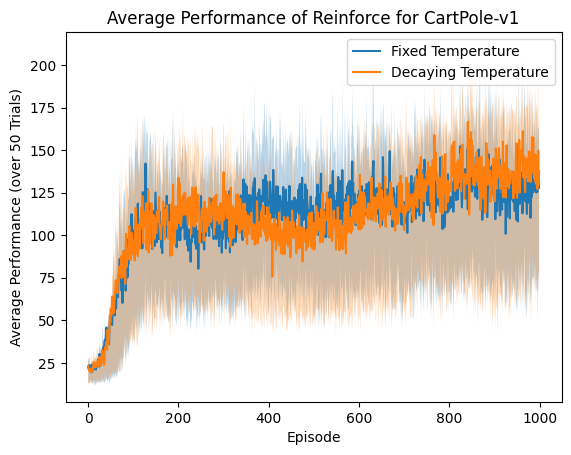

In [38]:
plot_avg_performance(rf_mean_const,rf_performance_const,rf_mean_decay,rf_performance_decay,method = "Reinforce for CartPole-v1")


Note: To speed things up, from now on, might use multiprocessing (implementation above)

ActorCritic

In [26]:
AgentCls = ActorCritic
best_HPs,best_means,performances = hp_tuning(AgentCls,CartPole_env,a_thetas=[0.005,0.01],a_ws=[0.001,0.01],num_tilings_choices = [2,4,7,14], bins_choices=[14,20],gamma=1,start_temps = [10],end_temps = [5],temp_decay = True,num_trials = 3,num_best=3)

In [ ]:
print(best_means)
print(best_HPs)

In [ ]:
# Small Sample Plot

#(rf_sample_mean_decay,rf_sample_performance_decay) = performances[1]

#plot_avg_performance(rf_sample_mean_decay,rf_sample_performance_decay,rf_sample_mean_decay,rf_sample_performance_decay,method = "ActorCritic for CartPole-v1 (SAMPLE)")


In [65]:
# Now have a good idea of what HPs to use

ALPHA_THETA = 0.00005
ALPHA_w = 0.0001 # Useless w/o baseline = True
GAMMA = 1 # since episodic
START_TEMP_DECAY = 0.1
TEMP_CONST = 5

In [ ]:
AgentCls = ActorCritic

rf_mean_const,rf_performance_const = run_threaded_experiments(AgentCls,CartPole_env, ALPHA_THETA,ALPHA_w, GAMMA, TEMP_CONST,num_tilings = 2,num_bins=32,baseline=False,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp= 0.1)
rf_mean_decay,rf_performance_decay = run_threaded_experiments(AgentCls,CartPole_env, ALPHA_THETA,ALPHA_w, GAMMA, START_TEMP_DECAY,num_tilings = 2,num_bins=32,baseline=False,num_trials=50,num_episodes = 1000,temp_decay = True, end_temp= 5)

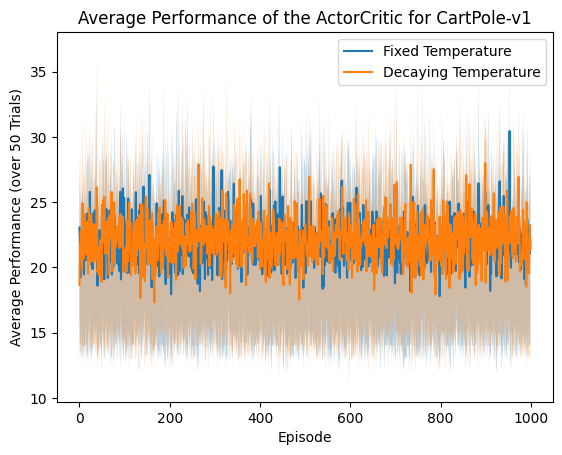

In [ ]:
plot_avg_performance(rf_mean_const,rf_performance_const,rf_mean_decay,rf_performance_decay,method = "ActorCritic for CartPole-v1")


In [71]:

ALPHA_THETA = 0.0005
ALPHA_w = 0.0001 # Useless w/o baseline = True
GAMMA = 1 # since episodic
START_TEMP_DECAY = 0.1
TEMP_CONST = 5

In [ ]:
AgentCls = ActorCritic

rf_mean_const,rf_performance_const = run_threaded_experiments(AgentCls,CartPole_env, ALPHA_THETA,ALPHA_w, GAMMA, TEMP_CONST,num_tilings = 2,num_bins=32,baseline=False,num_trials=1,num_episodes = 1000,temp_decay = False, end_temp= 0.1,theta_init=0)
#rf_mean_decay,rf_performance_decay = run_threaded_experiments(AgentCls,CartPole_env, ALPHA_THETA,ALPHA_w, GAMMA, START_TEMP_DECAY,num_tilings = 2,num_bins=32,baseline=False,num_trials=1,num_episodes = 1000,temp_decay = True, end_temp= 5)

plot_avg_performance(rf_mean_const,rf_performance_const,rf_mean_const,rf_performance_const,method = "ActorCritic for CartPole-v1")


#### MountainCar

In [12]:
env = gym.make("MountainCar-v0")

Reinforce

In [ ]:
#rf_car_best_HPs,rf_car_best_means,rf_car_performances = hp_tuning(Reinforce,env,a_thetas=[0.01],a_ws=[0.01],num_tilings_choices = [10], bins_choices=[20],gamma=1,start_temps = [0.1],end_temps = [0.05],temp_decay = False,num_trials = 1,num_best=3,theta_init=0,baseline=False)

In [ ]:
# Small Sample Plot

#rf_car_sample_mean_decay,rf_car_sample_performance_decay = rf_car_performances[0]

#plot_avg_performance(rf_car_sample_mean_decay,rf_car_sample_performance_decay,rf_car_sample_mean_decay,rf_car_sample_performance_decay,method = "Reinforce for MountainCar-v0 (SAMPLE)")


In [15]:
# Have a good idea of what HPs to use (did AC first)

ALPHA_THETA = 0.01
ALPHA_w = 0.05
GAMMA = 1 # since episodic
START_TEMP_DECAY = 5
TEMP_CONST = 1
#TILINGS = 10
#NUM_BINS = 20

In [16]:
rf_car_mean_decay,rf_car_performance_decay = run_threaded_experiments(Reinforce,env, ALPHA_THETA,ALPHA_w, GAMMA, START_TEMP_DECAY,num_tilings = 8,num_bins=8,baseline=True,num_trials=50,num_episodes = 1000,temp_decay = True, end_temp= 1,theta_init = 0)

In [ ]:
rf_car_mean_const,rf_car_performance_const = run_threaded_experiments(Reinforce,env, ALPHA_THETA,ALPHA_w, GAMMA, TEMP_CONST,num_tilings = 8,num_bins=8,baseline=True,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp= 0.05,theta_init = 0)

In [ ]:
plot_avg_performance(rf_car_mean_decay,rf_car_performance_decay,rf_car_mean_decay,rf_car_performance_decay,method = "Actor Critic for MountainCar-v0")


Actor Critic

In [50]:
# Have a good idea of what HPs to use

ALPHA_THETA = 0.01
ALPHA_w = 0.01
GAMMA = 1 # since episodic
START_TEMP_DECAY = 0.1 # decay to 0.05
TEMP_CONST = 0.1
#TILINGS = 10
#NUM_BINS = 20

In [51]:


ac_car_mean_decay,ac_car_performance_decay = run_threaded_experiments(ActorCritic,env, ALPHA_THETA,ALPHA_w, GAMMA, START_TEMP_DECAY,num_tilings = 10,num_bins=20,baseline=False,num_trials=50,num_episodes = 1000,temp_decay = True, end_temp= 0.05,theta_init = 0)

In [52]:
ac_car_mean_const,ac_car_performance_const = run_threaded_experiments(ActorCritic,env, ALPHA_THETA,ALPHA_w, GAMMA, START_TEMP_DECAY,num_tilings = 10,num_bins=20,baseline=False,num_trials=50,num_episodes = 1000,temp_decay = False, end_temp= 0.05,theta_init = 0)

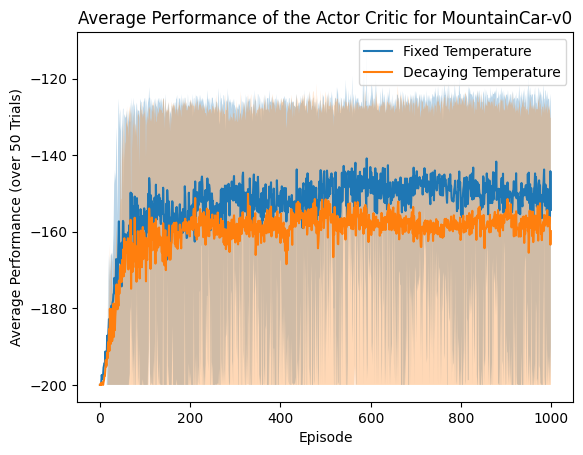

In [53]:
plot_avg_performance(ac_car_mean_const,ac_car_performance_const,ac_car_mean_decay,ac_car_performance_decay,method = "Actor Critic for MountainCar-v0")
